In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import seaborn as sns
import matplotlib as mpl

In [19]:
rad = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/catalogue/random_quasar_lss_all.npy')

In [21]:
len(rad)

6874160

In [2]:
from astropy.io import fits

In [3]:
quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_full = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_full_ALLdata-vDR16.fits')

quasar_all = np.hstack((quasar_n, quasar_s))

In [4]:
id_to_index = {id_: i for i, id_ in enumerate(quasar_full['QSO_ID'])}
index = np.zeros(len(quasar_all), int)
for i in range(len(quasar_all)):
    index[i] = id_to_index[quasar_all['QSO_ID'][i]]
matched_full = quasar_full[index]

In [5]:
id_to_index = {id_: i for i, id_ in enumerate(quasar_SDSS['OBJID'])}
index = np.zeros(len(matched_full), int)
OBJID = matched_full['OBJID_TARGETING'].astype('<U19')
for i in range(len(matched_full)):
    index[i] = id_to_index.get(OBJID[i], -1)
valid = index != -1
matched_SDSS = quasar_SDSS[index]

In [6]:
M_I = matched_SDSS['M_I'].astype(float)
M_I[~valid] = np.nan

In [7]:
z = quasar_all['Z'].astype(float)

thin = 0.05
thinned = np.random.choice(len(M_I), int(len(M_I)*thin), replace=False)

data = {'Z': z[thinned], 'M_I': M_I[thinned]}

In [8]:
z_edge = np.quantile(quasar_all['Z'], [1/3, 2/3])

bins = np.linspace(0.8, 2.2, 30)
result = np.digitize(quasar_all['Z'], bins)
L_sep = []
for i in range(1, 30):
    index = np.where(result == i)[0]
    M = M_I[index]
    middle = np.percentile(M[~np.isnan(M)], 50)
    L_sep.append(middle)
z_mid = bins[:-1] + np.diff(bins) / 2

In [9]:
mpl.rcParams['font.size'] = 20

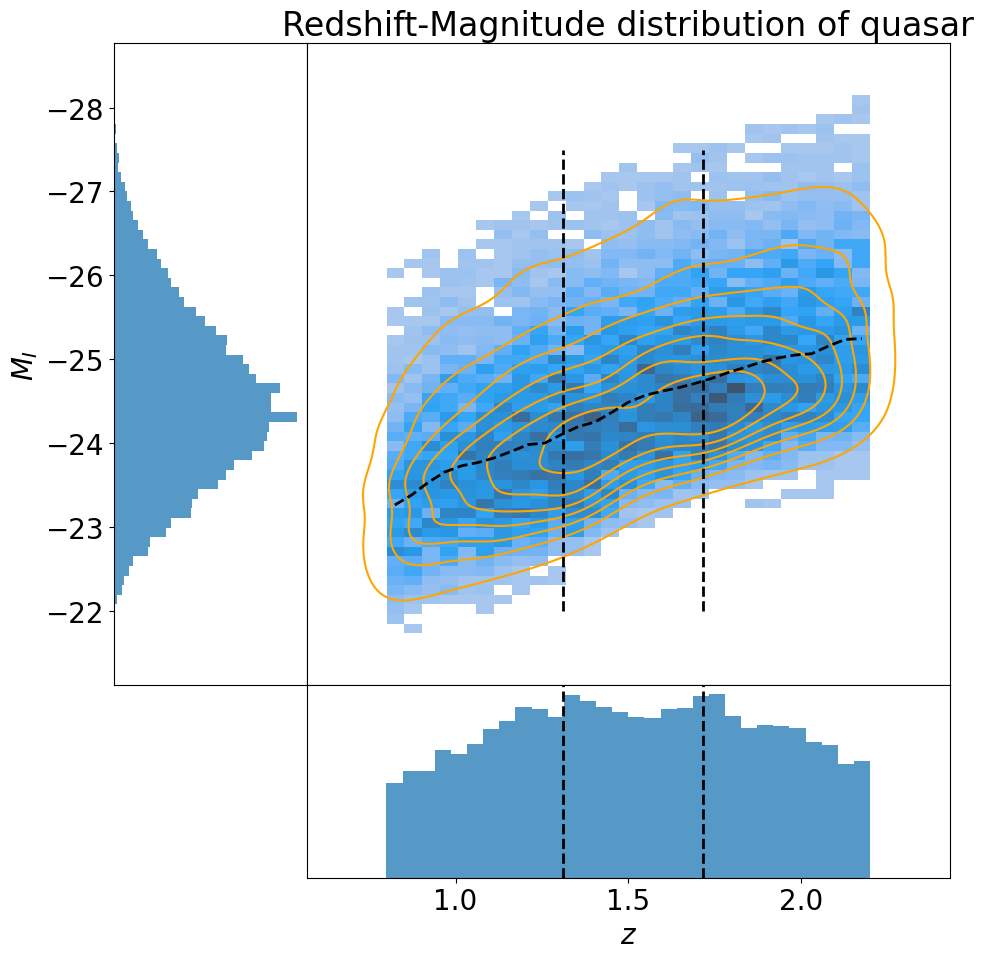

In [11]:
fig = plt.figure(figsize=(10, 10))

# Define a gridspec with appropriate width and height ratios
gs = fig.add_gridspec(2, 2, width_ratios=[0.3, 1], height_ratios=[1, 0.3], wspace=0, hspace=0)

# Create the subplots using the gridspec
ax_histy = fig.add_subplot(gs[0, 0])  # y histogram
ax_main = fig.add_subplot(gs[0, 1])   # main scatter/density plot
ax_histx = fig.add_subplot(gs[1, 1])  # x histogram
ax_empty = fig.add_subplot(gs[1, 0])  # empty subplot

# Hide the empty subplot
ax_empty.axis('off')

# Plot the main 2D distribution
sns.histplot(data, x='Z', y='M_I', ax=ax_main)
sns.kdeplot(data, x='Z', y='M_I', ax=ax_main, color='orange', levels=8)

# Plot the marginal distributions
sns.histplot(data, y='M_I', ax=ax_histy, linewidth=0)
sns.histplot(data, x='Z', ax=ax_histx, linewidth=0)

# Remove the 'count' label from histograms
ax_histy.set_xlabel('')
ax_histy.set_xticks([])
ax_histx.set_ylabel('')
ax_histx.set_yticks([])

# Invert y-axis for the main plot and y histogram
ax_main.invert_yaxis()
ax_histy.invert_yaxis()

# Align the y-axis between the main plot and y histogram
ax_histy.set_ylim(ax_main.get_ylim())

# Align the x-axis between the main plot and x histogram
ax_histx.set_xlim(ax_main.get_xlim())

# Move x-axis ticks and labels from main plot to x-histogram
ax_main.tick_params(axis='x', labelbottom=False, bottom=False)  # Remove x-tick labels from main plot
ax_histx.tick_params(labelbottom=True)  # Show x-tick labels on histogram
ax_histx.set_xlabel('$z$')  # Move x-label to histogram

# Move y-axis ticks and labels from main plot to y-histogram
ax_main.tick_params(axis='y', labelleft=False, left=False)  # Remove y-tick labels from main plot
ax_histy.tick_params(labelleft=True)  # Show y-tick labels on histogram
ax_histy.set_ylabel('$M_I$')  # Move y-label to histogram

# ax_histy.spines['top'].set_visible(True)
# ax_histy.spines['right'].set_visible(False)  # Hide the right spine since it connects to main plot
# ax_histy.spines['bottom'].set_visible(True)
# ax_histy.spines['left'].set_visible(True)

# ax_histx.spines['top'].set_visible(False)
# ax_histx.spines['right'].set_visible(True)
# ax_histx.spines['bottom'].set_visible(True)
# ax_histx.spines['left'].set_visible(True)  # Hide the left spine since it connects to main plot

# Add titles and labels
ax_main.set_title('Redshift-Magnitude distribution of quasar')
ax_main.set_xlabel('')
ax_main.set_ylabel('')

# Add vertical lines and separation curve
ax_main.vlines(z_edge, -22, -27.5, color='black', linestyle='dashed', linewidth=2)
ax_main.plot(z_mid, L_sep, '--', color='black', linewidth=2)

# Add vertical lines to the x-histogram
u, d = ax_histx.get_ylim()
ax_histx.vlines(z_edge, u, d, color='black', linestyle='dashed', linewidth=2)
ax_histx.set_ylim(u, d)

# Adjust layout
plt.tight_layout()
plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/z-L.pdf')

plt.show()

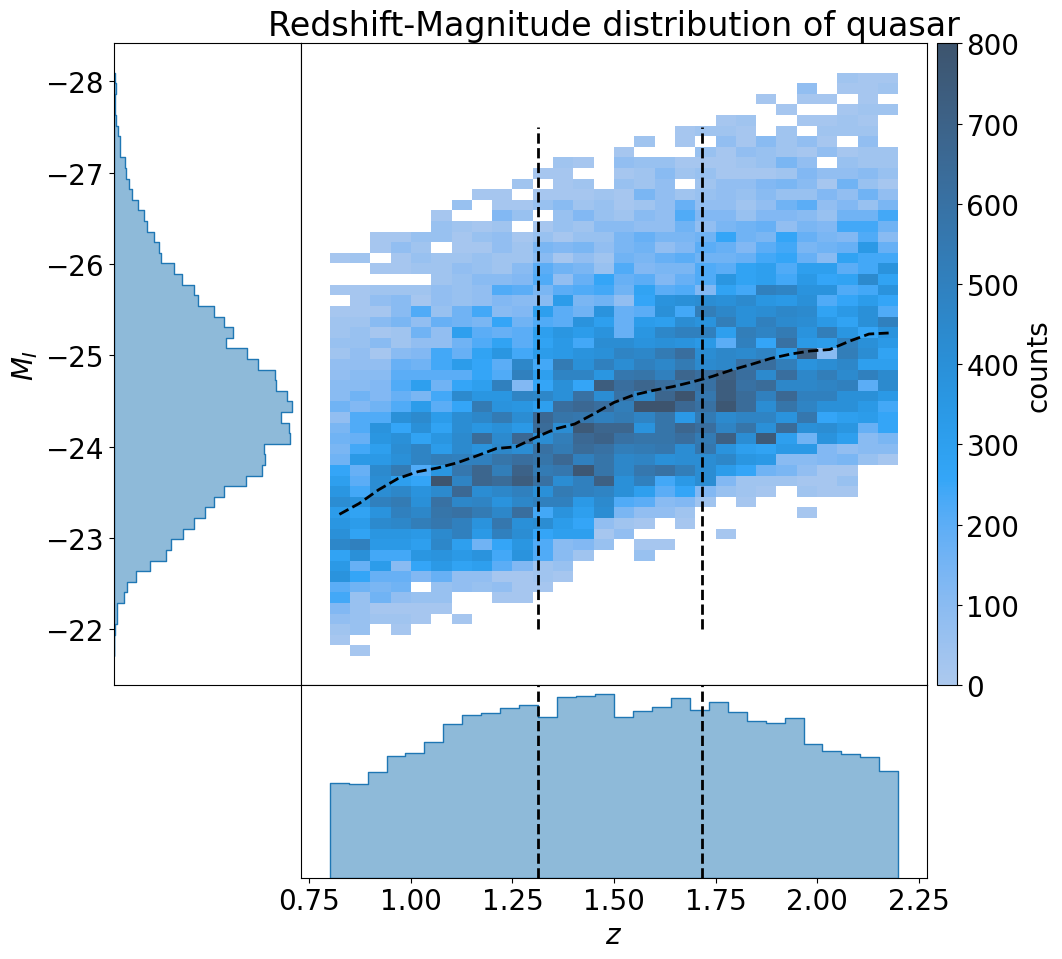

In [18]:
fig = plt.figure(figsize=(10, 10))

# Define a gridspec with appropriate width and height ratios
gs = fig.add_gridspec(2, 2, width_ratios=[0.3, 1], height_ratios=[1, 0.3], wspace=0, hspace=0)

# Create the subplots using the gridspec
ax_histy = fig.add_subplot(gs[0, 0])  # y histogram
ax_main = fig.add_subplot(gs[0, 1])   # main scatter/density plot
ax_histx = fig.add_subplot(gs[1, 1])  # x histogram
ax_empty = fig.add_subplot(gs[1, 0])  # empty subplot

# Hide the empty subplot
ax_empty.axis('off')

# Plot the main 2D distribution
sns.histplot(data, x='Z', y='M_I', ax=ax_main)
# sns.kdeplot(data, x='Z', y='M_I', ax=ax_main, color='orange', levels=8)

# Plot the marginal distributions
sns.histplot(data, y='M_I', ax=ax_histy, element='step', alpha=0.5)
sns.histplot(data, x='Z', ax=ax_histx, element='step', alpha=0.5)

# Remove the 'count' label from histograms
ax_histy.set_xlabel('')
ax_histy.set_xticks([])
ax_histx.set_ylabel('')
ax_histx.set_yticks([])

# Invert y-axis for the main plot and y histogram
ax_main.invert_yaxis()
ax_histy.invert_yaxis()

# Align the y-axis between the main plot and y histogram
ax_histy.set_ylim(ax_main.get_ylim())

# Align the x-axis between the main plot and x histogram
ax_histx.set_xlim(ax_main.get_xlim())

# Move x-axis ticks and labels from main plot to x-histogram
ax_main.tick_params(axis='x', labelbottom=False, bottom=False)  # Remove x-tick labels from main plot
ax_histx.tick_params(labelbottom=True)  # Show x-tick labels on histogram
ax_histx.set_xlabel('$z$')  # Move x-label to histogram

# Move y-axis ticks and labels from main plot to y-histogram
ax_main.tick_params(axis='y', labelleft=False, left=False)  # Remove y-tick labels from main plot
ax_histy.tick_params(labelleft=True)  # Show y-tick labels on histogram
ax_histy.set_ylabel('$M_I$')  # Move y-label to histogram
# Add titles and labels
ax_main.set_title('Redshift-Magnitude distribution of quasar')
ax_main.set_xlabel('')
ax_main.set_ylabel('')

# Add vertical lines and separation curve
ax_main.vlines(z_edge, -22, -27.5, color='black', linestyle='dashed', linewidth=2)
ax_main.plot(z_mid, L_sep, '--', color='black', linewidth=2)

# Add vertical lines to the x-histogram
u, d = ax_histx.get_ylim()
ax_histx.vlines(z_edge, u, d, color='black', linestyle='dashed', linewidth=2)
ax_histx.set_ylim(u, d)



# Adjust layout
plt.tight_layout()

# Add a colorbar for the 2D histogram
# grab the QuadMesh created by sns.histplot
mesh = ax_main.collections[0]
pos = ax_main.get_position()
# place colorbar aligned to ax_main (right side) with a small gap
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh, cax=cax)
cbar.set_label('counts')

# multiply the numeric tick labels by 50 (e.g. 40 -> 2000)
formatter = mpl.ticker.FuncFormatter(lambda val, pos: f'{int(val/thin):d}')
cbar.ax.yaxis.set_major_formatter(formatter)

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/z-L.pdf', bbox_inches='tight')

plt.show()

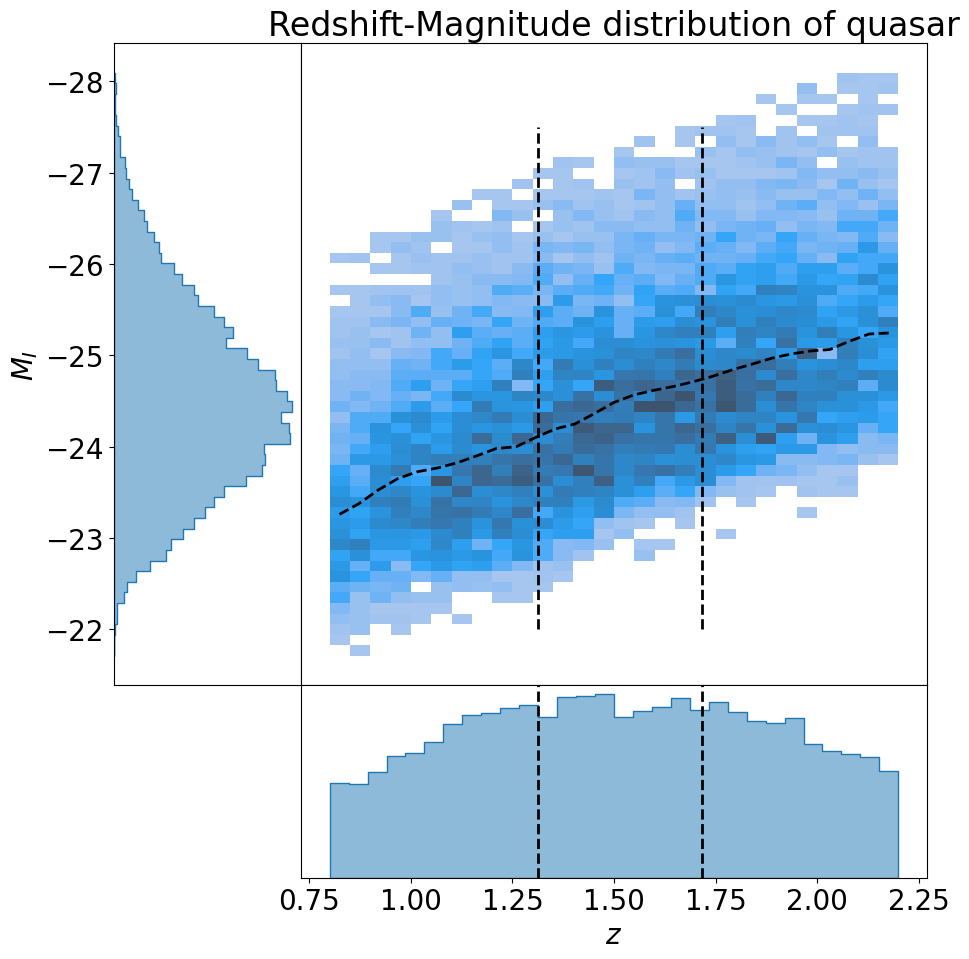

In [ ]:
fig = plt.figure(figsize=(10, 10))

# Define a gridspec with appropriate width and height ratios
gs = fig.add_gridspec(2, 2, width_ratios=[0.3, 1], height_ratios=[1, 0.3], wspace=0, hspace=0)

# Create the subplots using the gridspec
ax_histy = fig.add_subplot(gs[0, 0])  # y histogram
ax_main = fig.add_subplot(gs[0, 1])   # main scatter/density plot
ax_histx = fig.add_subplot(gs[1, 1])  # x histogram
ax_empty = fig.add_subplot(gs[1, 0])  # empty subplot

# Hide the empty subplot
ax_empty.axis('off')

# Plot the main 2D distribution
sns.histplot(data, x='Z', y='M_I', ax=ax_main)
# sns.kdeplot(data, x='Z', y='M_I', ax=ax_main, color='orange', levels=8)

# Plot the marginal distributions
sns.histplot(data, y='M_I', ax=ax_histy, element='step', alpha=0.5)
sns.histplot(data, x='Z', ax=ax_histx, element='step', alpha=0.5)

# Remove the 'count' label from histograms
ax_histy.set_xlabel('')
ax_histy.set_xticks([])
ax_histx.set_ylabel('')
ax_histx.set_yticks([])

# Invert y-axis for the main plot and y histogram
ax_main.invert_yaxis()
ax_histy.invert_yaxis()

# Align the y-axis between the main plot and y histogram
ax_histy.set_ylim(ax_main.get_ylim())

# Align the x-axis between the main plot and x histogram
ax_histx.set_xlim(ax_main.get_xlim())

# Move x-axis ticks and labels from main plot to x-histogram
ax_main.tick_params(axis='x', labelbottom=False, bottom=False)  # Remove x-tick labels from main plot
ax_histx.tick_params(labelbottom=True)  # Show x-tick labels on histogram
ax_histx.set_xlabel('$z$')  # Move x-label to histogram

# Move y-axis ticks and labels from main plot to y-histogram
ax_main.tick_params(axis='y', labelleft=False, left=False)  # Remove y-tick labels from main plot
ax_histy.tick_params(labelleft=True)  # Show y-tick labels on histogram
ax_histy.set_ylabel('$M_I$')  # Move y-label to histogram
# Add titles and labels
ax_main.set_title('Redshift-Magnitude distribution of quasar')
ax_main.set_xlabel('')
ax_main.set_ylabel('')

# Add vertical lines and separation curve
ax_main.vlines(z_edge, -22, -27.5, color='black', linestyle='dashed', linewidth=2)
ax_main.plot(z_mid, L_sep, '--', color='black', linewidth=2)

# Add vertical lines to the x-histogram
u, d = ax_histx.get_ylim()
ax_histx.vlines(z_edge, u, d, color='black', linestyle='dashed', linewidth=2)
ax_histx.set_ylim(u, d)

# Adjust layout
plt.tight_layout()
plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/z-L.pdf')

plt.show()